# Walking using the Linear Inverted Pendulum Model

In this exercise, we will use the linear inverted pendulum model (LIPM) seen in class as a model for bipedal walking and we will derive a model predictive control law that will stabilize walking in face of external disturbances.

The LIPM can be derived from the (complicated) dynamics of any legged robot. It describes the dynamics of the Center of Mass (CoM) of the robot when we assume that the CoM height is constant and that the angular momentum at the CoM is 0.

<img src="lipm.png" alt="missing LIPM figure" width="400"/>

In this case, the motion of the CoM in the horizontal plane (forward and side motions) can be written as a linear dynamical system. In particular, the forward and side motions are decoupled. In the following, we will only consider forward motions and ignore side movement. The forward motion of the CoM, using this model, can be written
$$\begin{align}\dot{x} &= v \\ \dot{v} &= \omega(x - u)\end{align}$$
where $x$ is the CoM position, $v$ its velocity, $\omega = \frac{g}{z}$, $z$ is the CoM height, $g$ the gravity constant and $u$ is the center of pressure (CoP) location on the ground.

We know that, to be physically consistent, the CoP needs to be located inside the support polygon formed by the feet on the ground. In the case where one foot is on the ground, the CoP needs to be inside the foot.

Since the differential equation is linear, we can explicitly solve it for a given $\Delta t$ assuming a constant center of pressure during that time. We then get the following linear discrete system
$$\begin{bmatrix} x_{n+1} \\ v_{n+1} \end{bmatrix} = \begin{bmatrix} \cosh(\omega \Delta t) & \omega^{-1} \sinh(\omega \Delta t) \\ \omega \sinh(\omega \Delta t) & \cosh(\omega \Delta t) \end{bmatrix} \begin{bmatrix} x_{n} \\ v_{n} \end{bmatrix} + \begin{bmatrix} 1 - \cosh(\omega \Delta t) \\ -\omega \sinh(\omega \Delta t) \end{bmatrix} u_n$$

The idea is to find CoP locations (which will then be realized by an another controller on the real robot) such that we can move the CoM where we want and such that the CoP is always inside the support polygon. We will assume that there is only one leg touching the ground at a time. Assuming that the foot on the ground is located at time $n$ at $f_n$ and that the foot has a length of $l_{foot}$, the CoP constraint reads
$$f_n - \frac{l_{foot}}{2} <u_n<f_n + \frac{l_{foot}}{2}$$
We will also assume that we predefine the foot step locations in advance.

We now have almost all the ingredients necessary to construct an optimal control problem. We just need a cost function. Here, to keep the problem simple, we will assume that during walking, we try to keep the CoM above the foot in contact as much as possible and that we try to keep the CoP at the center of the foot as much as possible. We will also try to keep the velocity of the CoM as small as possible. We therefore have the following optimal control problem
$$\min_{u_n} \sum_{n=0}^{N-1} \left( \begin{matrix} x_n - f_n \\ v_n \end{matrix} \right) ^T Q \left(\begin{matrix} x_n - f_n \\ v_n \end{matrix}\right) + (u_n - f_n)^T R (u_n - f_n) + \left( \begin{matrix} x_N - f_N \\ v_N \end{matrix}\right)^T Q_N \left(\begin{matrix} x_N - f_N \\ v_N \end{matrix}\right)$$
subject to
$$\begin{bmatrix} x_{n+1} \\ v_{n+1} \end{bmatrix} = \begin{bmatrix} \cosh(\omega \Delta t) & \omega^{-1} \sinh(\omega \Delta t) \\ \omega \sinh(\omega \Delta t) & \cosh(\omega \Delta t) \end{bmatrix} \begin{bmatrix} x_{n} \\ v_{n} \end{bmatrix} + \begin{bmatrix} 1 - \cosh(\omega \Delta t) \\ -\omega \sinh(\omega \Delta t) \end{bmatrix} u_n$$
and
$$f_n - \frac{l_{foot}}{2} <u_n<f_n + \frac{l_{foot}}{2}$$

In [1]:
# setup matplotlib for nice display in Jupyter
%matplotlib notebook

# a few libraries we will need
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp

import cvxopt

# note in order to use the animation package to display movies you will need to install ffmpeg
# on Mac with homebrew: brew install ffmpeg
# on ubuntu: apt-get install ffmpeg
# on windows: https://ffmpeg.org/download.html#build-windows
import matplotlib.animation as animation

import IPython

np.set_printoptions(precision=5,linewidth=120,suppress=True)

## Solving a constrained linear optimal control problem

We provide the function below to solve LQ optimal control problems with constraints as we have seen in class. We will use this solver to construct a model predictive controller for walking. The function solves problems of the form
$$\min_{u_n} \sum_{n=0}^{N-1} x_n^T Q_n x_n + q_n^T x_n + u_n^T R_n u_n + r_n^T u_n$$
subject to
$$x_{n+1} = A x_n + B u_n,\qquad x_0 = x(0)$$
and
$$G_n \begin{bmatrix}x_n \\ u_n \end{bmatrix} \leq h_n$$
where the dynamics is independent of $n$ and the costs and bounds can change at every time step.

In [2]:
def solve_mpc_collocation(A,B,Q,q,R,r,G_bounds, h_bounds, horizon_length, x0):
    """
    Here we want to do MPC with a collocation approach
    we assume that A and B are constant but Q, q, R, r and the bounds are given as list of vectors/matrices
    one per time step
    
    it returns a state trajectory and a control trajectory
    """
    # the number of states we will need to optimize for
    num_states = x0.size*horizon_length
    u_size = B.shape[1]
    # the number of control to optimize
    num_control = u_size*horizon_length
    # the total number of variables we need to optimize
    num_vars = num_states + num_control

    # the total Hessian of the problem (the quadratic part) [x u]^T Qtot [x u]
    Qtilde = np.zeros([num_vars, num_vars])
    # the total linear part
    qtilde = np.zeros([num_vars, 1])
    
    Atilde = np.zeros([num_states, num_vars])
    btilde = np.zeros([num_states])
    # we impose the initial condition x0
    btilde[0:x0.size] = -A.dot(x0)
    
    G_tilde = None
    h_tilde = None


    for i in range(horizon_length):
        # we put Q and R in the right places on the diagonal
        Qtilde[x0.size*i:x0.size*(i+1), x0.size*i:x0.size*(i+1)] = Q[i]
        Qtilde[num_states+u_size*i:num_states+u_size*(i+1), num_states+u_size*i:num_states+u_size*(i+1)] = R[i]
       
        # same for q and r
        qtilde[i*x0.size:(i+1)*x0.size] = q[i]
        qtilde[num_states+i*u_size:num_states+(i+1)*u_size] = r[i]
    
        # we construct the equality constraint for the dynamics
        Atilde[x0.size*i:x0.size*(i+1),num_states+u_size*i:num_states+u_size*(i+1)] = B
        if i>0:
            Atilde[x0.size*i:x0.size*(i+1), x0.size*(i-1):x0.size*(i+1)] = np.hstack((A, -np.eye(x0.size)))
        else:
            Atilde[x0.size*i:x0.size*(i+1), x0.size*(i):x0.size*(i+1)] = -np.eye(x0.size)
        
        # now we construct the inequalities Gtilde [x u] <= htild
        G_tmp = np.zeros([G_bounds[i].shape[0], num_vars])
        G_tmp[:, x0.size*i:x0.size*(i+1)] = G_bounds[i][:,:x0.size]
        G_tmp[:, num_states+u_size*i:num_states+u_size*(i+1)] = G_bounds[i][:,x0.size:]
        if G_tilde is None:
            G_tilde = G_tmp
        else:
            G_tilde = np.vstack((G_tilde, G_tmp))

        if h_tilde is None:
            h_tilde = h_bounds[i]
        else:
            h_tilde = np.vstack((h_tilde, h_bounds[i]))
        
            
    # we transform our data into cvxopt complicant data
    Qtot = cvxopt.matrix(Qtilde)
    p = cvxopt.matrix(qtilde)
    
    G = cvxopt.matrix(G_tilde)
    h = cvxopt.matrix(h_tilde.flatten())
    
    Atilde = cvxopt.matrix(Atilde)
    btilde = cvxopt.matrix(btilde)
    
    #now we call cvxopt to solve the quadratic program constructed above
    cvxopt.solvers.options['show_progress'] = False
    sol = cvxopt.solvers.qp(Qtot,p,G,h,Atilde, btilde)
    x = np.array(sol['x'])
    u = x[num_states:]
    x = x[0:num_states]

    return  np.vstack((x0, x.reshape([horizon_length, x0.size]))).T, u.T

## Simulation of the LIPM

In [3]:
class LIPM:
    """
    This class implements a linear inverted pendulum model - we will use it to simulate the walking robot
    """
    
    def __init__(self):
        """
        constructor of the class
        """        
        #gravity constant
        self.g=9.81
        
        #CoM height
        self.z_com = 1.0

        #integration step (100ms)
        self.dt = 0.1
        
        #
        self.omega = np.sqrt(self.g / self.z_com)
        
        #the transition matrices
        self.A = np.array([[np.cosh(self.dt*self.omega), 1./self.omega * np.sinh(self.dt*self.omega)],
                          [self.omega * np.sinh(self.dt*self.omega), np.cosh(self.dt*self.omega)]])
        self.B = np.array([[1 - np.cosh(self.dt*self.omega)],[-self.omega * np.sinh(self.dt*self.omega)]])
        
        # half of the size of the foot (i.e. the foot is 30cm long)
        self.foot_size = 0.15        
                        
    def next_state(self,x,u):
        """
        Inputs:
        x: state of the system as a numpy array (x,v)
        u: cop position as a scalar
        
        Output:
        the new state as a numpy array
        """
        
        return self.A.dot(x) + self.B.dot(u)
        
    
    def simulate(self, x0, controller, horizon_length, foot_steps, noise=True):
        """
        This function simulates the LIPM for horizon_length steps from initial state x0
        
        Inputs:
        x0: the initial conditions as a numpy array (x,v)
        controller: a function that takes a state x as argument and index i of the time step and returns a control u
        horizon_length: the horizon length
        foot_steps: an array containing foot step locations for every time step (this is used to ensure u is constrained to the support polygon)
        
        Output:
        x[2xtime_horizon+1] and u[1,time_horizon] containing the time evolution of states and control
        """
        x=np.empty([2, horizon_length+1])
        x[:,0] = x0
        u=np.empty([1,horizon_length])
        for i in range(horizon_length):
            u[:,i] = np.clip(controller(x[:,i],i), foot_steps[i]-self.foot_size, foot_steps[i]+self.foot_size)
            x[:,i+1] = self.next_state(x[:,i], u[:,i])
            if i>0 and noise:
                disturbance = np.random.normal(0., 0.01)
                x[1,i+1] += disturbance
        return x, u

## Animation and plotting utility

In [4]:
def animate_walker(plotx, plotu, foot_pose):
    """
    This function makes an animation showing the behavior of the LIPM with some graphics showing the CoP, etc.
    takes as input the result of a simulation (with dt=0.1s), the CoP position (plotu) and the foot step locations fn (foot_pose)
    """
    use_dt = 100
    
    feet_colors = ['b','g']
    c_foot_c = 0
    
    fig = mp.figure.Figure(figsize=[8.5,2.4])
    mp.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-0.2,9], ylim=[-.2,2.3])
    ax.grid()
    
    list_of_lines = []
    
    #plot the ground
    ax.plot([-0.1,8],  [0,0])
    
    #create the walker
    line, = ax.plot([], [], feet_colors[c_foot_c], lw=2)
    list_of_lines.append(line)
    #for the CoP
    line, = ax.plot([], [], 'or', ms=8)
    list_of_lines.append(line)
    #for the CoM
    line, = ax.plot([], [], 'ok', ms=10)
    list_of_lines.append(line)
    #for the torso
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    #for the head
    line, = ax.plot([], [], 'ok', ms=10)
    list_of_lines.append(line)
    #for the foot
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    
    com_height = 1.
    torso_height = 1.
    
    def animate(i):
        nonlocal c_foot_c
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        if i>0:
            if foot_pose[i] != foot_pose[i-1]:
                c_foot_c = (c_foot_c + 1)%2
                list_of_lines[0].set_color(feet_colors[c_foot_c])
                                        
        list_of_lines[0].set_data([foot_pose[i], plotx[0,i]], [0, com_height])
        list_of_lines[1].set_data([plotu[0,i], plotu[0,i]], [0, 0])
        list_of_lines[2].set_data([plotx[0,i], plotx[0,i]], [com_height, com_height])
        list_of_lines[3].set_data([plotx[0,i], plotx[0,i]], [com_height, com_height+torso_height])
        list_of_lines[4].set_data([plotx[0,i], plotx[0,i]], [com_height+torso_height, com_height+torso_height])
        list_of_lines[5].set_data([foot_pose[i]-0.15, foot_pose[i]+0.15], [0, 0])
        
        return list_of_lines
    
    def init():
        return animate(0)

    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:-1])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

In [5]:
def plot_results(x_real, u_real, x_plan, u_plan):
    """ this function plots the results of the simulations"""
    
    time = np.linspace(0,horizon_length*walking_model.dt, len(x_real[0,:]))
    plt.figure(figsize=[8,5])
    # plt.subplot(3,1,1)
    plt.plot(time, x_real[0,:], linewidth=6, label='Simulated CoM')
    plt.plot(time, x_plan[0,:], '--', linewidth=6, label='Planned CoM')
    plt.ylim([-1,10])
    plt.xlabel('Time [s]')
    plt.ylabel('CoM position')
    plt.legend()

    plt.figure(figsize=[8,5])
    plt.plot(time, x_real[1,:], linewidth=6, label='Simulated CoM Vel')
    plt.plot(time, x_plan[1,:], '--', linewidth=6, label='Planned CoM Vel')
    plt.ylim([-1,2])
    plt.xlabel('Time [s]')
    plt.ylabel('CoM velocity')
    plt.legend()

    plt.figure(figsize=[8,5])
    plt.plot(time[:-1], u_plan[0,:] - foot_position, linewidth=6, label='Planned CoP in foot')
    plt.plot(time[:-1], u_real[0,:] - foot_position, '--', linewidth=6, label='Simulated CoP in foot')
    plt.plot(time[:-1], np.zeros([len(foot_position)]) + walking_model.foot_size, 'k--', label='upper foot limit')
    plt.plot(time[:-1], np.zeros([len(foot_position)]) - walking_model.foot_size, 'k--', label='lower foot limit')
    plt.xlabel('Time [s]')
    plt.ylabel('CoP position and limits')
    plt.legend()
    
    plt.figure(figsize=[8,5])
    plt.plot(time, x_real[0,:], linewidth=6, label='CoM')
    plt.plot(time[:-1], u_real[0,:], linewidth=6, label='CoP')
    plt.plot(time[:-1], foot_position, 'k', label='foot position')
    plt.plot(time[:-1], foot_position + walking_model.foot_size, 'k--', label='foot boundary')
    plt.plot(time[:-1], foot_position - walking_model.foot_size, 'k--', label='foot boundary')
    plt.xlabel('Time [s]')
    plt.ylabel('Complete simulated pattern')
    plt.legend()

# Planning a walking trajectory 
We can plan a walking trajectory by solving the OC problem above as follows

<IPython.core.display.Javascript object>


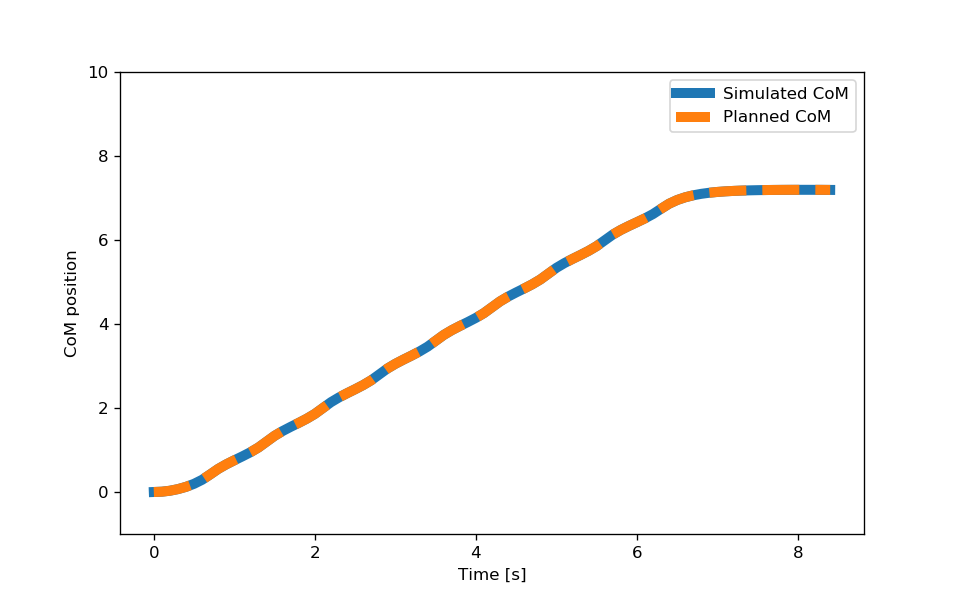

<IPython.core.display.Javascript object>


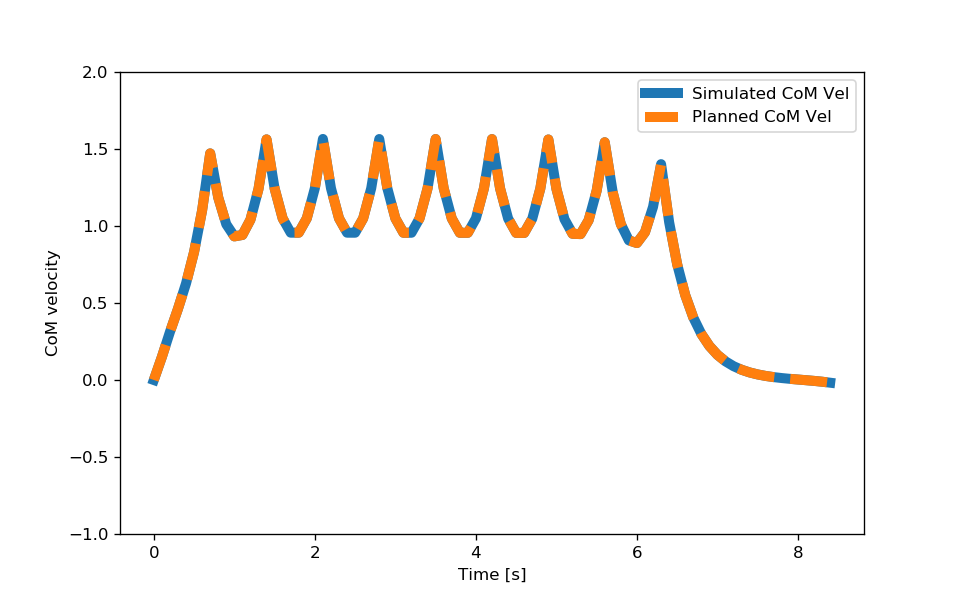

<IPython.core.display.Javascript object>


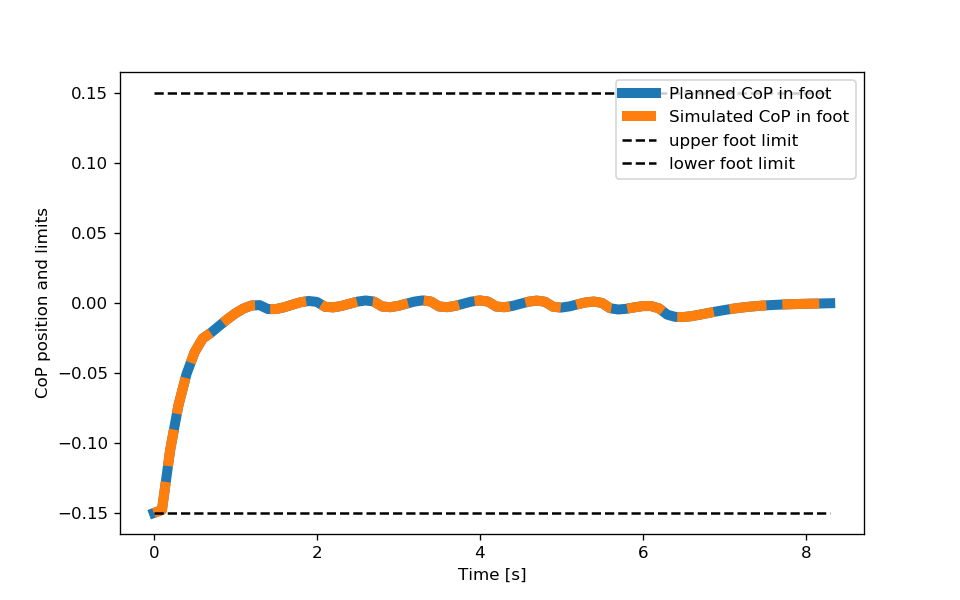

<IPython.core.display.Javascript object>


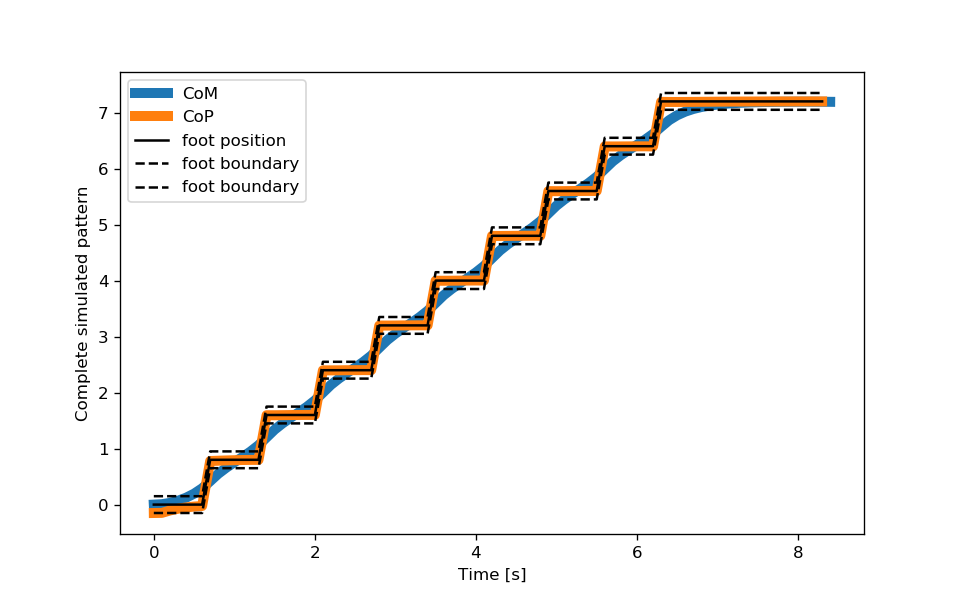

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABkD21kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAyWZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0S01mbztHQVmSva4/vXAq3t9p2GeBk+t6G1IAPnWY86z/ienmnvyw6g7Vofvc
HctObctagCEdk41dOjdBxwTMv3gihBeTO2ZvQFWwO1gVYHWe0ccN50QFYa79vn1yWXD0FYjKAahj
ZKP26bT2it+CynYkUuHi2gYsRwYlSVO/+ZQIfQ+4C+XIFjphAZbmOcdwu2wwaf+QclE2IUVk7ICD
zJkRF6bTnhVTeGhZaVM5t1tp76QeYwtZ9a21U6INDaifb7bmglsL3t0dY5yMs2KHRRi8RXEKWcKa
MnzG1VD+/AU6OYKATvKjhAXqMLMbiJzWiZTGFMRFwgoDNbeRbmdnww2mxWaOX1/k5HT6HQFNlQd1
yn/owY4/iYFgdGsEBCujqtfUzBMvW+dU598s6MgYI7WvNsmPcakqOVN+6tuNzQldFsEXd8zQ3Djt
jIQueSBx+AhxF66o1lGfQ1Sl8zxhJjn55+Va1W6NWvjXLzKKUuEUEgkuPrm+oVNsVe5kxCLjIRRn
C3S2NuvSYMts/aNI7Ak7T+Bz+Ds60qiAvF4L3gRXQJeCcZ95aH1vbJiq4S7ptGnkn6VfwefgmPE+
ticnowuV/ZpFfRS+BmW/BtuO8fcaZp85775knOBKXVHdiNDmBrJvFkFBs36P813VOh4R9T0GyTpr
se1EJ0nT1vHky0ZzJ6YWCzwJe8P11VwM2riaYLjc+kE9lTgb5qMY8h455eGZ1CHnpsYxjISCLo6s
qC9KvjF9fHzTC1xseyh/EoayU2C1lvDE1sLxfAU29+uX75KJ313jTPBpI852p1qA1ne5UQVq8dFu
th28mkHzpgwM+qHET2RjUNZ5NL1+RFmQD+S0C0knYb/NR2ZfGZwRFPNu213ApAzJtEfnhHgqpgS1
inlu9HjlGBBY2bbwUmWm85+Btrv1B38Fi2WWXqAWMNylE6OcmPkJxcmGUVcGu7Jr/wQSQ1naJ/we
fzet84h2BygmVR63gugbjd+DpohzRMNeq8xppA9dUeVugKQA6QY9+XFV9+lmNZrsvKawk1BpS0xO
cz1hxxbfqWTD7MzD4FXy2Vx5VS4DoD+KypOUrSSvh6WJmhbRlx2nBmdtcQpPOFnXnMUsK2+bhoxw
TfS5JHSYbBB37UwZnuUgbeZ8iUfN8LLooUYylQCMG9HKTpKUQsi5jqTJ7XypmgKJhFJC3/f+CeOj
4/jdx6efzENEUxvtHgfNa2DRdw3ZfstV1oPsfqW34PuQ8NUu77znw8rZc4zBPJktKqswwMP/fzFk
gtOVoX5JkQg99i3kqmHMIsRaoKaf2wMp4GDlvrX7m9SbPkhsMT8vgh7/itx1VTRA1hnczAqWTeAm
VTHmHL/aOwm5FF8lbO2j8FLPbWu51ObBcR+EHuuXPVE6k0yfXKpuGWtSt0m59jyc3Dg6RQTDV7cc
MaIBjqFSClZ0VXKxGwrSbGdVy4tmVXiS3jmGd1YNO8wlYYnCldcNSi+JfWyQVAKVUhr6N32B6tmv
orG5Bg5dSUpAusRyLLqfzWCtlpcLkdcP8jxzrH0ozf6zB83XFr/lECcSkjf/haqQbfzIJ3MWrLJv
rIq+iZSpXy1+8M/2P9m7xxlDjy+ULedIfJJSwWNOfq/5u7ML8c6I5IAAt8nN/gKd+Zyk/qDQriZ5
yz9ByvO15WdUQx0oP6N78FUkRGqgYHvflJRMFWqaQG7ncRtj4Qwz3vsqC6OHm8R6GjBD586uV3Qg
k+DetB2yv4mMjGZf5D73qLjBMrHoE3zVJPgPZ7r0jIg4Li+YTF78GWyFIkyk7QZmjL6pqjEHWVfu
/l5Np4j6lJBXalI0RJdSHOH+LlVwNQOmMvc2i72c3x2Z854vdu5PYZtICUvV/bX4LDW5dB9ZpQ/v
GvT6az6t84DXDzdJ0DZgUpAXjtc8fv1Ya3yz8HrmI46tthEirhvrWhmK+/GQ+IKnPeRoVg4tAPXk
EA4QSOtULPeRt3UBbmNYqx1RA/iTiS3vJbjE5d8zRBbI8V57HFklrH4eexHob7IDMhRyY7JroG2x
HEpgKjXEe3p9UclQhfKdXlEYExRAx1996ifPOLM14hqMzYmZrgWo0SrczIDSiXX/sYoMy6L2npBC
lVwJqprH+sfNnmskhC+qEeFvHAMGAcE8EgiC2Tags4HjGpSs6Rsg7T7zfxv2lmBo8+00dSpKT5fv
Jaa3lX3gWYUQ4quYBtQJEie485NHLB7HML7I2Q/W2VwpEMNU77cHrEC4S6Q71hUQoLZljSiruP30
TcdLU/1B9Kb2LkoLUQIB9XFZ01alcufWs5W2grjCWDpXdmACebzdatmBAVAHZFgCnYGOk1Ma9+7o
D2m/nKR+7TzYpIVi5Zv/jU/Pog92i//8rRn3ptvDx6jGZKtdDLlhM/lrVb20qAEW+j//18vv84l8
COaZfhIoadM+4a+G2K2x8x9M4d3WDi9gX39PqmDql5AQMoTY2Xhurh8dWEi/aC4vaexqKxXrAdZQ
BwiALhcLptoT06qzGtaqY5tuwAkoLkERJ2Q/s5+BgdqqoVnbZcAIgkQP6qRppX0ZsZdF1CxGPLBg
VRKeoIrktumnpxhDfrQvlLH1DD+W+qzAoLSQHw5J8O7mrvisdEA6ZdcRkJLEqa+Vtu+Ry5GU7mGm
d/fhPJMkhRbIzioWeBkicvf3M1ApPXO0+m/sOkn5o7pJ3eciHwCjkgpYyXlhPcwhv6mR3Vjk9ovg
8LyXNjcYpc1Tltu31gYd+qE2kmNO4kiunxTNTSUjJRkKVStfSE2XExM2vJSfkanACbrr+w4Goj9J
dSDgKt3zhi+yoQoz0NiYx

In [6]:
# first lets create a walking model
walking_model = LIPM()

# assume we start at rest
x0 = np.array([0.,0.])

# we set the time taken by the robot to take one full step
step_time = 0.7 #in seconds
iterations_per_step = int(round(step_time / walking_model.dt))

# the length of a step is 0.8 meters
step_length = 0.8

# we would like to make 10 steps and then stop
num_steps = 10

# the horizon length including the number of steps and two cycles without stepping
horizon_length = num_steps * iterations_per_step + 2 * iterations_per_step

# now we create a vector that contains the desired foot locations at every time step
foot_position = np.zeros([horizon_length])

# for the 10 steps
for i in range(num_steps):
    foot_position[i*iterations_per_step:(i+1)*iterations_per_step] = i*step_length
# for the last cycle we stay in place
foot_position[num_steps*iterations_per_step:] = (num_steps-1)*0.8

# now we can construct the optimal control problem as follows
# we will define bounds of the form G_bounds [x u]^T < h_bounds
G_bounds = []
h_bounds = []
# the cost function is rewritten in the form 0.5(x u)^T Q (x u) + q^T x + 0.5uRu + r^T u to take into account the linear terms
Q = []
q = []
R = []
r = []

# we will fill the lists for each time step
for i in range(horizon_length):
    Q_nominal = np.eye(2)
    Q.append(Q_nominal)
    # we want the CoM above the foot and 0 velocity
    q.append(Q_nominal.dot(np.array([[-foot_position[i]],[0.]])))
    
    R_nominal = 100*np.eye(1)
    R.append(R_nominal)
    # we want the CoP in the center of the foot
    r.append(R_nominal.dot(np.array([-foot_position[i]])))
    
    # we create bounds for the CoP location
    G_bounds.append(np.array([[0,0,1],[0,0,-1]]))
    h_bounds.append(np.array([[walking_model.foot_size+foot_position[i]],[walking_model.foot_size-foot_position[i]]]))

# now we can solve the problem using the collocation method (solving a single quadratic program gives a x and u trajectory in time)
x_plan, u_plan = solve_mpc_collocation(walking_model.A,walking_model.B,Q,q,R,r,G_bounds, h_bounds, horizon_length, x0)

# we now define a controller that will simply use the computed u as a control
feedforward_controller = lambda x,i: u_plan[0,i]

# we simulate the LIPM using the feedforward controller (no noise)
x_real,u_real = walking_model.simulate(x0, feedforward_controller, horizon_length, foot_position, noise=False)

# we plot the resulting motion vs. the motion that was planned and the associated CoP
plot_results(x_real, u_real, x_plan, u_plan)
animate_walker(x_real, u_real, foot_position)

We are able to compute a plan but when the simulation has noise (e.g. the robot gets pushed or we need to account for errors coming from the simplification of the LIPM vs. the real robot), the plan cannot get the robot to walk. This is shown below.

<IPython.core.display.Javascript object>


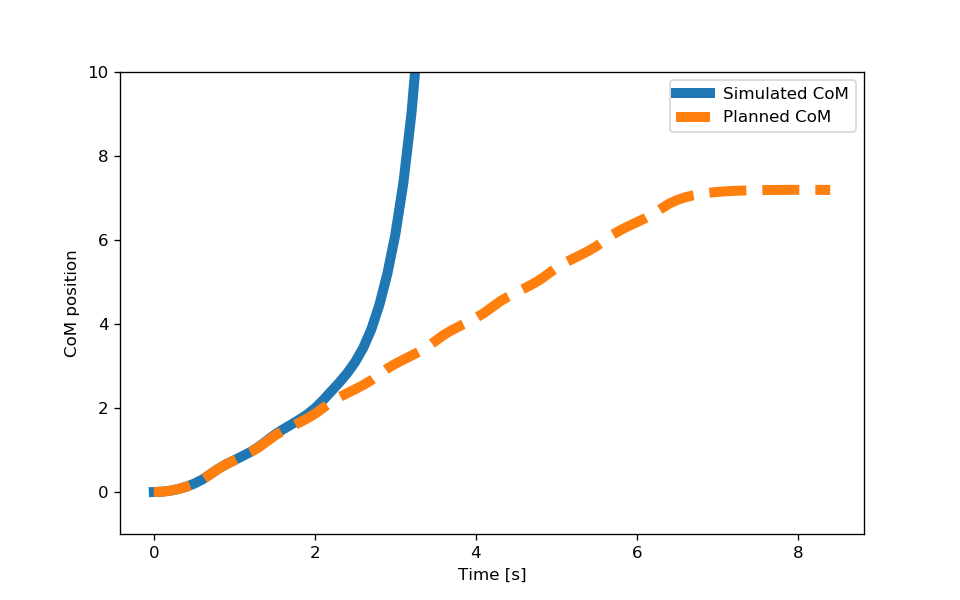

<IPython.core.display.Javascript object>


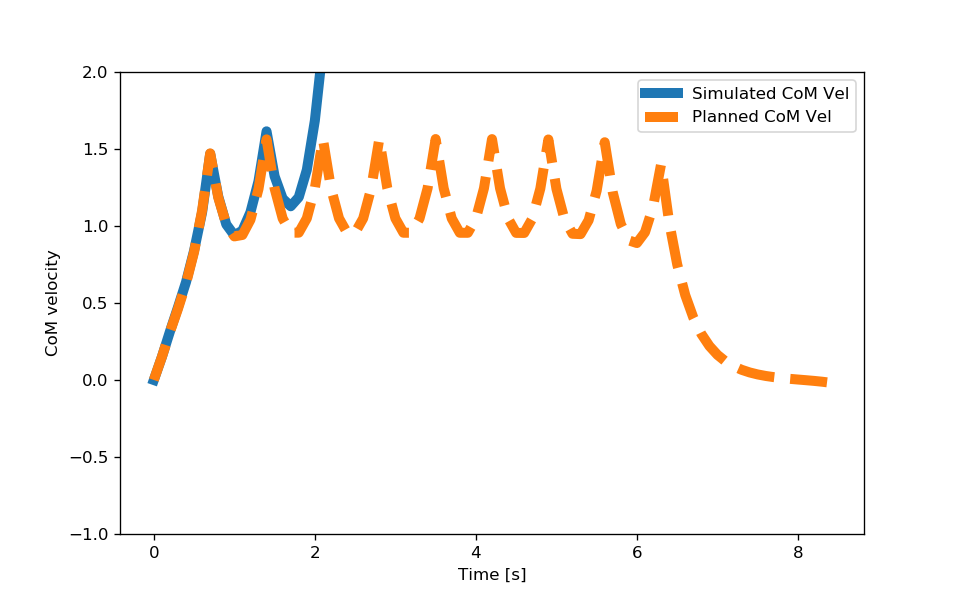

<IPython.core.display.Javascript object>


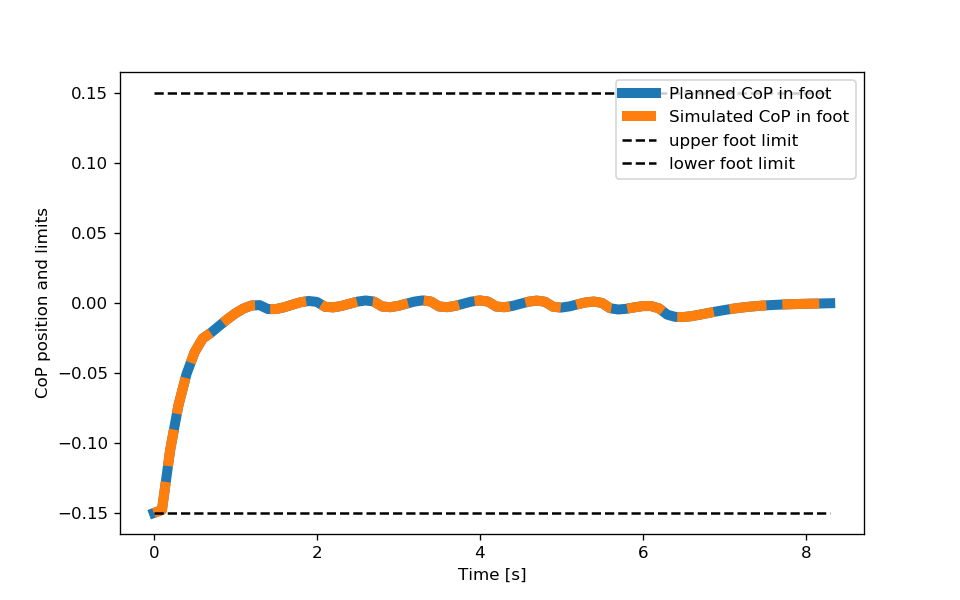

<IPython.core.display.Javascript object>


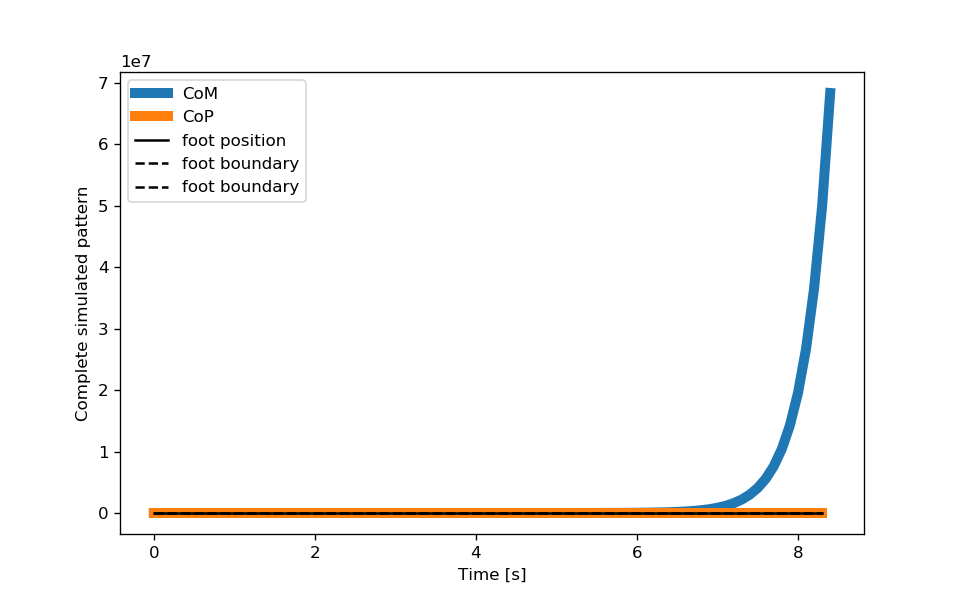

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABl8W1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAx9ZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0Sz5UKgQ+DJCu8qNwLKtf4Xpch6Lj56/OdnRZRsN004evpExoKLSO7vMC1urE
FzyyfcE90UjC6Qr54Aufhqfv29n+YdlBGG7KEQIKJLcI3lrbJcybjSRBmsL5m4XMVZjJ8qpqxEnf
filYhZJ7a94KzvVqRmMiXEo5F5sG9BraBoET/q4Yrjus3Jt6idK3WTGsPxx/XhNaG6VPfkvrvt/k
AXSVEw3jmkyIi7I0qJtuvm7fgVWDi+ypui0DDJPMuvpjCwjVlOD3dCjcz2WF8cbsL2C/FgMM7Vos
zwdKdYrnGpfRp7kHVNMGoI5bcrgywaSLxrwa6Qq/tRvog4dbmrC7fx9GO+dz6T30C69zw2XhM3aH
oFNlQd11puOyIzZ6ByO/Ss/GFdEF9Nr+hpgV1Twqx8s6Mf4w7XMzpwizlXotoYkFJUeN+Lp5DGoj
urY3zvziG7kDwUcaRJtBoKIKyZ55/Gh/QkAmKJGRL22mt3OxnqOMJip3d+SSw1+L1i9GJPt7MUgS
kUvRnR5uJbxzdF/kLTE8cdxmiLxP8Dn8EmQ+xFleHM3CLVQ/P4iY3XpVkBC+/xXNkjV/T38eDw42
PS2T62Jybz5yv7NIr6KXwK6CQbbjvHxdZjPnOgbz3/SjJ8agl4I3/cFSEdJ5XVCtEVw98RWGs+g1
/yqFjxVS+CDCRvNRivv49Jq+h917OlPM0MnsvzlxCF/xGZycnyyyU9iKvw8S90abl+t43yje7lSI
IjWL/1Zp+MNnmHBh2d5GwHfhA06/xx14MLmzbvh9N/OvTV/Y/stN9OQIgENORzVYFZuJyHI2lwOX
8hM8MVXMldTaVRRKvVyYSVaH7eQthhLsIAWswCZaw9+gCHth2Q2RPOFHkAxU3PI9ciYc5iCoAJKg
zMWiyIHTCTnyy9V3eJbkKPwqs2omBQttHaAZmWrEHIdcNLEwUiV912QlHVYpMLWt3/9mLgOcNvRr
Jymdt1uIAopbXX2JfEOWLgbvoYl39xFKdanIYTr7H1WAzawpADpBj35cVXw2WtrI3AJaPajIicmX
9p0HDoVuJGWk7l/Tliy1Hkh91+0uA6A/ir1zvcfIIaGItAwxaMuO04MztriExS52Pwryf537X2yW
Fcb5PJI6V72rlC0GK4BwaG/zeqozUHmP5wx8+y3d8r182BtSlELIuAgKoRV9ghT9ZZZ+G3/f+iVX
QBYmuSQcdlFzTAriQThBIJ78872ifrP7j8hVXWg+x+opLtNB8vak9mjnah1YFWkix1tEkyD64/8m
iA+ziBEE3JYpXHITq8r/1pomUgs4e9sTlouyNGWQo3lPqrYAN69mJTSDzrF6Ma/sNZ8OVDlvo2AX
FhcgVw/rJJ77+2EgotM7YYUPKTf51Whwg6Wu2BofxejDJoC1DsWgE0kAGuABfj5YS+3MGxCg4q3v
J1ock4mYsyku7WNltYvpb/Nn1bG/LC8RthZ5ndWDTvUZl+76AwUMxAHVn/9IFQClVIa+jd9gercI
iBnyty4xC0jxpSsHiyz2UMAq+nAqnINV4SQ3EEZ9NmE1581FAltOH+4lZNv/C1Ug3AELXpnYOAFf
ARXhGlKlfLX8tR/sie92J+N+3Oj6SoLUwf8l/nnEKC5x/5Sjv5H19kAAGb+MGGuCkBgmn5S8TPOW
gCRnwaDpqIwEacxUrSonxsSYIEecAK/vL+W+wTdAND7ZXAkNxeulCVncbjSYx68g1BAMe0FS9lr6
KX3tu9PSJIkZ9DX5bPtDUBL1lDenpPHCNXRopX1dCSmHhZa7vwZbIAC7/yfbmpbny+MNsWbfHF+G
k2niPqUkFdqUjAENx7AWhNJ9XA1A6eDVwIh1ZzfHZnyXHbwYXeuzaQEpd8ynT5wMYH9l9Z6A/vHv
iwBtnYyNI12124wjqRUpAXjtc8jP1bkJByc6gcRx1bbCJFXDfWtDMV9+J7jqc4bI2pWlVAzyqgPo
h5TjvVTNWQeaI8uQzpHwmJHTlY8ABLkiiEmStGVNaybhLkQHo8o/SlcPRQSXb6sfpcHRL8/1Dcmd
pKR6yoPJb014iWDwYqjfHENesw4tshBU2yrI/NI9lP6WM2uc4E1U1j/WPmWDZLuQe5HRNqa4QHzV
UW2OkcmrG7I7MG9NVCsKFrlC2j1s6VeT+HdqOk3QydwaOpZPetP6ZuAh0Ysf4iG+q23dPx8MRKsU
QJcv19EhSRMKl0z9BVBMZ9rFv2oqMNzHzFDdaVspwZj/05XH63V3i5LfW9+3hP4vOizrPfEVqL3E
CeX9S8Xhb88ZgBj2E7Pr4JCEK5/AAAkzSfuJ6t86Li5Owo5zYUYRjp/9R+UMIkizc/+Hr/+y4rY0
MHv8j+LnF4USQC3N5tkZGqMqo+A//8tkGvNaWCpRXAfZXdpnXc5hxlT+39dgOI3EKD7qRpN1OuAg
YZvNsuMt2HCzYEdxMt92cbHDEyZXFu4EAa3sYwz0kPubxV0FgAhu8OLq4nrzZMNqa/n6HwTscYS5
y6t5ygy2Srk7T68xseAJgZ5q3EfKC4tdLpa+JWMK9epFcJpTRAau+fkt49vKEjSPSLzoUMwI4xh0
kzHRqHzkWMq18TlB/E13oPqNdvqym0lj8DF+7GG1zZ63RNDsithJXu69i4SA1kpsa49hQy4oJ2nb
gRjzkQ+AUckF9L/WEW85YLXIvct+K23m1wLhSzOfXRMYYzyIcSD0hWVCbSTGncSRXUAj4S2lokRZ
U8svGc29wuZQi/WqwdtzgBN11/YcQqUrjRaqXqRz5wxfZiEZQu56MHXXMTURhAIepHJUahru/0j8
kvdVJDIWPxt8D9DVbqHJz

In [7]:
# we simulate the LIPM using the feedforward controller when the simulation has noise
x_real,u_real = walking_model.simulate(x0, feedforward_controller, horizon_length, foot_position, noise=True)

plot_results(x_real, u_real, x_plan, u_plan)
animate_walker(x_real, u_real, foot_position)

## Questions

## a) Using the example above and the OC solver, write a model predictive controller that re-computes the optimal control at every instant of time as a function of the current state x. The idea is to solve the original OC problem for a shorter horizon and apply only the first control and repeast at every iteration.


<IPython.core.display.Javascript object>


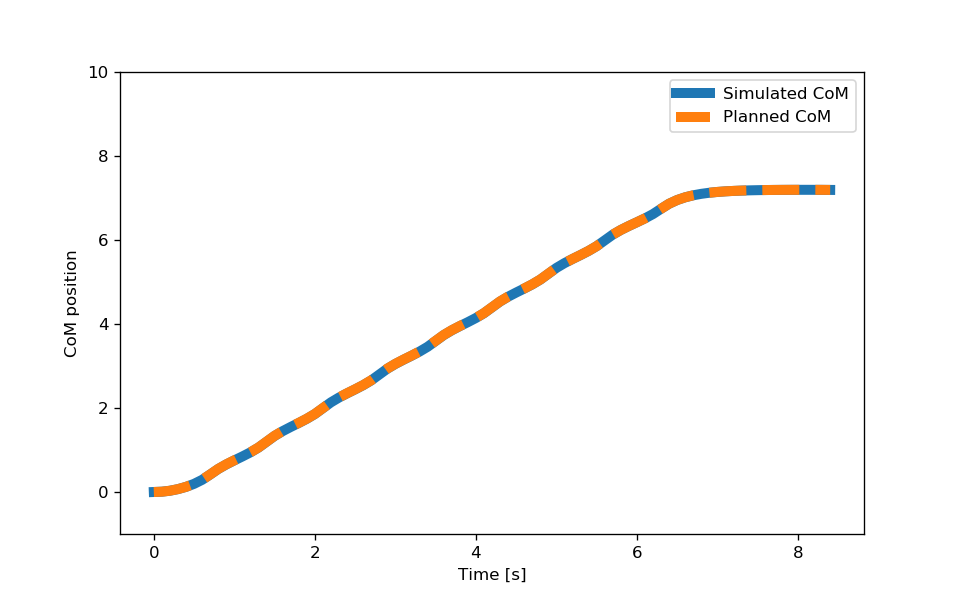

<IPython.core.display.Javascript object>


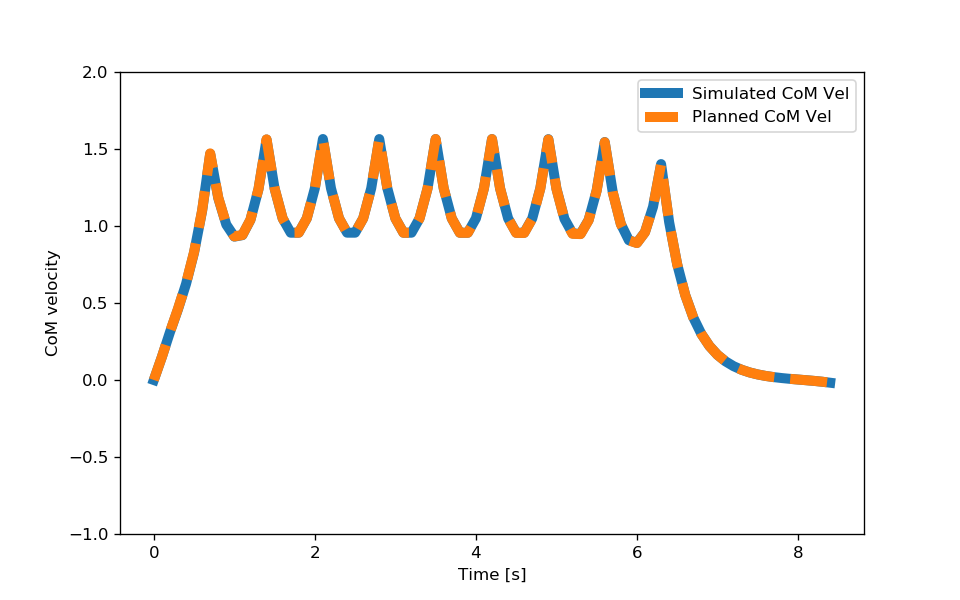

<IPython.core.display.Javascript object>


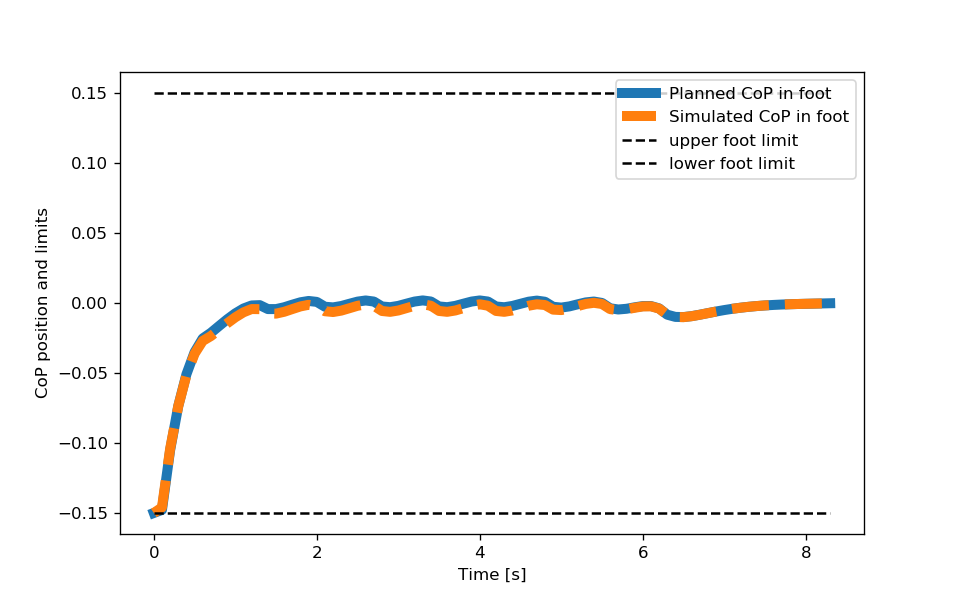

<IPython.core.display.Javascript object>


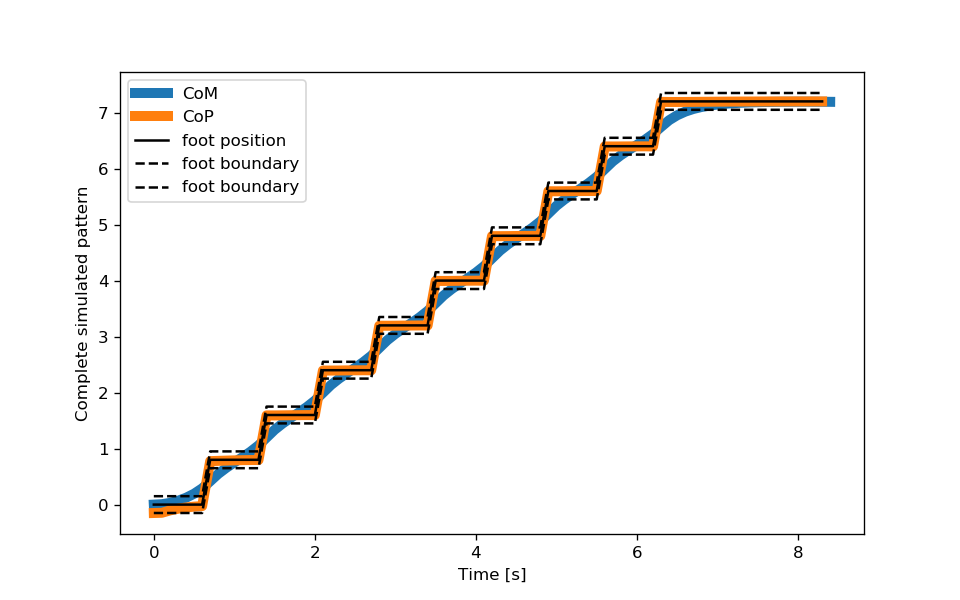

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABjYW1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAyMZYiE
ABD//veBvzLLXyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6J4P4R4lcQE8kYWQT6
y3KCuinXVt83n9H0Sz5UKgQ+DJCu8qNwLKtf4Xpch6Lj56/OdnRZRsN004evpExoKLSO7vMC1urE
FzyyfcE90UjC6Qr54Aufhqfv29n+YdlBGG7KEQIKJLcI3lrbJcybjSRBmsL5m4XMVZjJ8qpqxEnf
filYhZJ7a94KzvVqRmMiXEo5F5sG9BraBoET/q4Yrjus3Jt6idK3WTGsPxx/XhNaG6VPfkvrvt/k
AXSVEw3jmkyIi7I0qJtuvm7fgVWDi+ypui0DDJPMuvpjCwjVlOD3dCjcz2WF8cbdMDevR9I8ZW5Z
3S6U6xVBlS+jUvQOqaYNQRy25XBlg0kXjXg10r1/ajfRBw63MwF2/j6Md87n0nvoF17nhsvCZu0P
QKbKg7rrTcdkRmz0Dkd+lZ+MK6IL6bX9DTArqnhVj5Z0Y/xh2uZnThFnKvRbQxIKSo8b8XTyGNRH
dWxvnfnEN3IHgo40iTaDQUQVkzzz+ND+hIBMUSMiXttNbudjPUcYTFTu78klhr8XrF6MSfb2YpAl
IpejOjzcS3jm6L/IWmJ447jNEXif4HP4JMh9iLK8OZuEWqh+fxExuvSrICF9/iubJGr+nv48Hhxs
elsn1sTk3nzlf2aRX0UvgV0Eg23HePi6zGfOdA3nv+lGT41BLwRv+4KkI6TyuqFaIrh74a/Fsrx/
+5B3dCVwf2NKW3ageQDlIjmR7NnSnmaGT4f34LiLzUuRcx/8Nj7TrClE4dGm5freN8o5fOf5ERrL
/4byyxq9z8LimCenig77LCwb/njV6GzCwtYGVsu3E8MwkOjuQzP2Sx1ahmU4ZSQgz9mweYd/QhdW
KekmIYri7ZxMJX7AlmS7//oWrcY10pAIQaEm60nfn9D670Q2RvWnHkgx1AvI9ck2VChSlTs8AATk
yih6Ry08ljIN71N2mYn4XJTUTAoW2jtITHPdAdecfAobt38Mea0Jfpztli9n0CP9lKPA+f4C2Lak
ld4mXxfGRJhCJo3quooCg8frNo/C3FKFV3MNWP0wbXICkAOkGPflxVf4K8HidD71o9qMiJyZf2nQ
cOhkvfqWTD7MzD4FXwGVx5VS4DoD+Ku3O9x8ghoYi0JjFoy47TgzO2uIWUTnY/CvJ/nftfbXoVxv
k8kjpXvas7vIgZT/0Q3ub1VGag8x/OGPMem7vlevmwNqUohZFz7SrT2vcpavtdXo4Fv+/9E9peFz
o5JBx2UW8NXBtLpUiBzOofUon1+uDj9ORZeIVVJJNwhq7hpozrb5bWYytwJrTChWjIufKKgFW1eY
wEPY0WC4CA1wU+StJ1gRftIgD78ga3v6nqZHBFWC8OI0c5oH4YVacbJ+8/zNqlJTrgAQNzFgnZs/
u7GAB/Tg3pkWny/XKx8Z80oyWAADEzca+DH8T3wC7lzKcrLymehfplsvytZlB/Hj020L9dPg39+t
7Xd0wGeL+7a4h0MC0ZrLU28BlDZIUVdG2jIyO+/JXi+lPpDE4UrrhqhwVjEMSCoBSqkNfRu+wPUp
4RAz5W5cYhaR40pWac2EjKGAVfTlu7nrbtokNxBGfTZhgyfNRQJbTh/uJZ1O/wtVINwBxx+kv/QJ
vswreOhJoe+r9tz/shOBeocZdlQOPq3nSHySgBZPhQXOP/KUd/FejWEAANI/mVZskqBKvxs2HXlD
uAkZ8Gh4yRhIY6R0fJ4eQqTMECPN6xlCl/LfYJbDHZfvT5ld6nfzZ6mZGOCLWX/vJHbXVVHzJA04
S8CBDkKvoj6EtCJD8O8nWIjIKn1lU0tNfakqfo6WNMUIIGvagemUE3AL9RXtNAYOWoD/0Oi/55pt
jDsKpv1Vg6S/GyrtlYearldReVhdbFdvIOF2SZdZ+DHVveMdmfOdZc5KfTF6QEpeDyHX0iZlUwv3
Ls/94a37a8TJNHoa5ebpOgbSKlIC8drnlFjWIpXfZkwyymOrbYRIq4b61oZivvwLcdTlxAGQipVQ
M8qn6ngD1bqIktz6m2qMZkj+PW68gc4c2iEXcAMfQDdeA58KCxtoyprWTcJciA9HlH6SDMKBVHeu
qx+lwdEvz/UNycMwpHrKg8lvTXiJYPBiqN8OD96zDi2yEFTbKsj9k3RrjB+1DKlRfk1U1j/WPllX
IqmRZ6ZbTgEcVzV7B/z3SOTVl8NuMvsior3OAsmEoMtY8Ud0W0Pz4biHq7g0lfv/0URTdm58EDj/
EQ31W27p+PeQlqGCBLl+voj+YjgV2+2Jz/HzRedrq8u5xIDhs/HXFRezgSv+nK4/W6u8XJb65Fca
qUv0VSSs5a2KHUdq7AP3eLwt+eMwAyIB49Mx5tLqU7cRh0AlxZ11oI0WmT/GDwHsdtfoDn/rAIMj
rmVIo//TaSUH97dZR6P6/dAbW5//NsjbIyNUZVR7p//vCjf81sGgfDHAfa4UVy1gQO8luoT9vH9m
s28JGEtSboerqBPCCQVDqt2HCzYEdxMuMobABahoV3FvNkba3sYw3yYNutjyf4/v1Xh4HGCk1S0e
NE1Blmr9emCY6+gj1EKsOWv2I3jjYQwWafdQpwxTIm2Kg5QYNx+G16MojWWCrUeHuylOI5qNyhi9
DtEMcIhLvhCXrtkxJDzCSUPV2QtqzhoPwSNkE07JTFFDb4zdFyGR9+N2xA+owMXi6YLz0WAVVNG3
+TUZsa49hQy4oJ2lhfUC9uCje8RmCxp/rCLecsFrkRULxFUmBBcC4UszmCPueoWeRDiQe5+NUJtJ
MadxJFdPbJXwkdMlGQpVK19JRKOyMN38N4kY4YDCXXX9hwMGHGNFqpepFhYZrPMQf7dgnYQhy1iS
WMKCD1ASvreDR9ZqWHDiw

In [29]:
x_real = np.empty([2,horizon_length+1])
u_real = np.empty([1,horizon_length])
x_real[:,0] = np.array([0.,0.])

Test_Horizon=23

# we will fill the lists for each time step
for i in range(horizon_length):
    last_index = i + Test_Horizon
    if last_index >= horizon_length:
        last_index = horizon_length
    Test_Horizon_Current = last_index - i 
    
    Q_current = Q[i:last_index]
    q_current = q[i:last_index]
    
    R_current = R[i:last_index]
    r_current = r[i:last_index]
    
    G_bounds_current = G_bounds[i:last_index]
    h_bounds_current = h_bounds[i:last_index]
    foot_position_current = foot_position[i:last_index]
    
    
    x0_current = x_real[:,i]
    horizon_length_current = Test_Horizon_Current;
    
    x_plan_current, u_plan_current = solve_mpc_collocation(walking_model.A,walking_model.B, Q_current, q_current, R_current, r_current, G_bounds_current, h_bounds_current,Test_Horizon_Current,x0_current)
    
    # we now define a controller that will simply use the computed u as a control
    feedforward_controller = lambda x,i: u_plan_current[0,i]
    
    x,u = walking_model.simulate(x0_current, feedforward_controller, horizon_length_current, foot_position_current, noise=True)
    u_real[:,i]= u[:,0]
    x_real[:,i+1] = x[:,1]
    
    
# now we can solve the problem using the collocation method (solving a single quadratic program gives a x and u trajectory in time)
x_plan, u_plan = solve_mpc_collocation(walking_model.A,walking_model.B,Q,q,R,r,G_bounds, h_bounds, horizon_length, x0)

# Generating Plots and Animation for comparision
plot_results(x_real, u_real, x_plan, u_plan)
animate_walker(x_real, u_real, foot_position)

## b) What is the shortest time horizon that you can use in the MPC controller while still getting a stable walking in a noisy environment? (the simulation is stochastic so you may want to test your algorithm several times to get an "average" behavior). 

### Answer:
The minimum horizon length for which the MPC controller can make walking stable is 11.


<IPython.core.display.Javascript object>


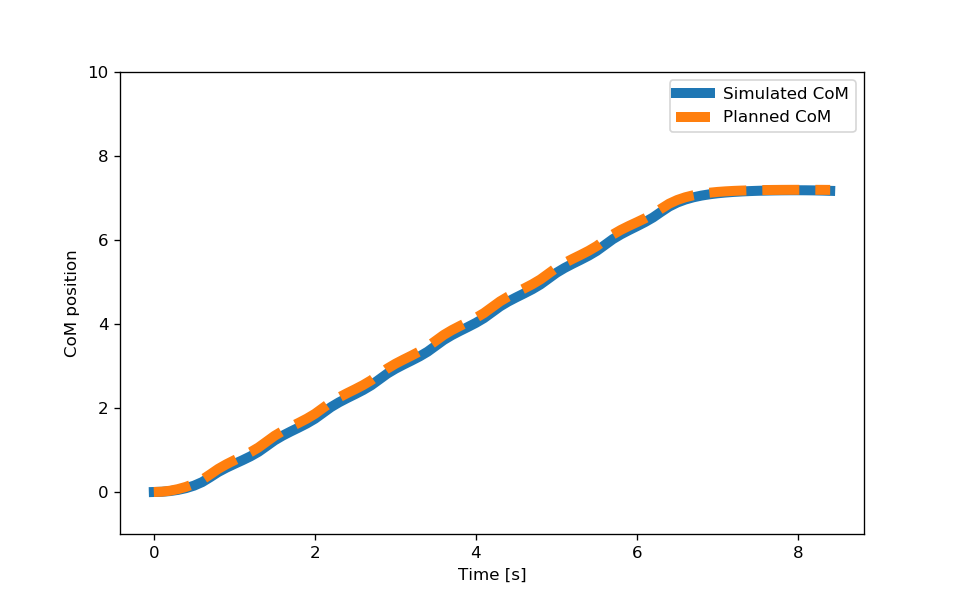

<IPython.core.display.Javascript object>


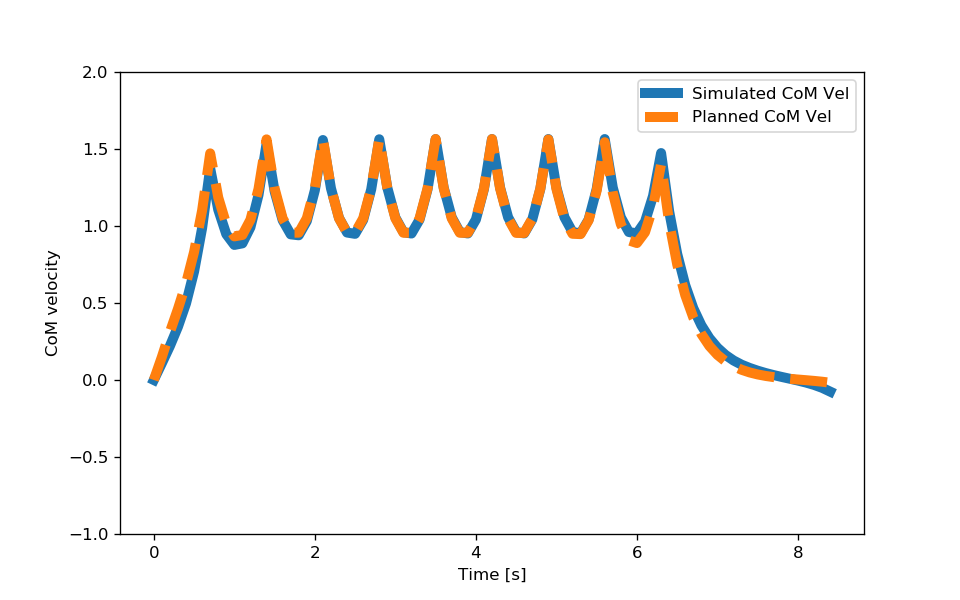

<IPython.core.display.Javascript object>


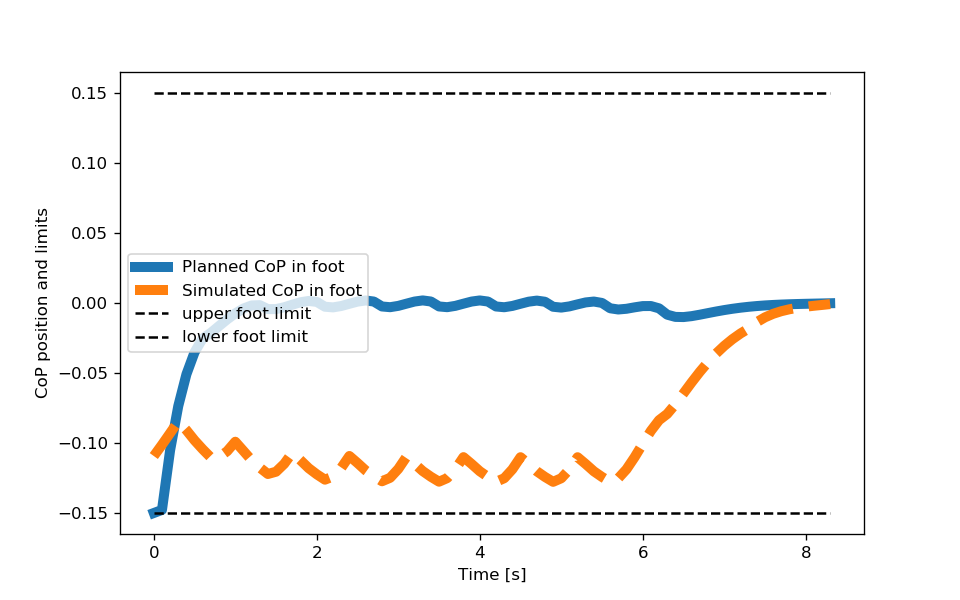

<IPython.core.display.Javascript object>


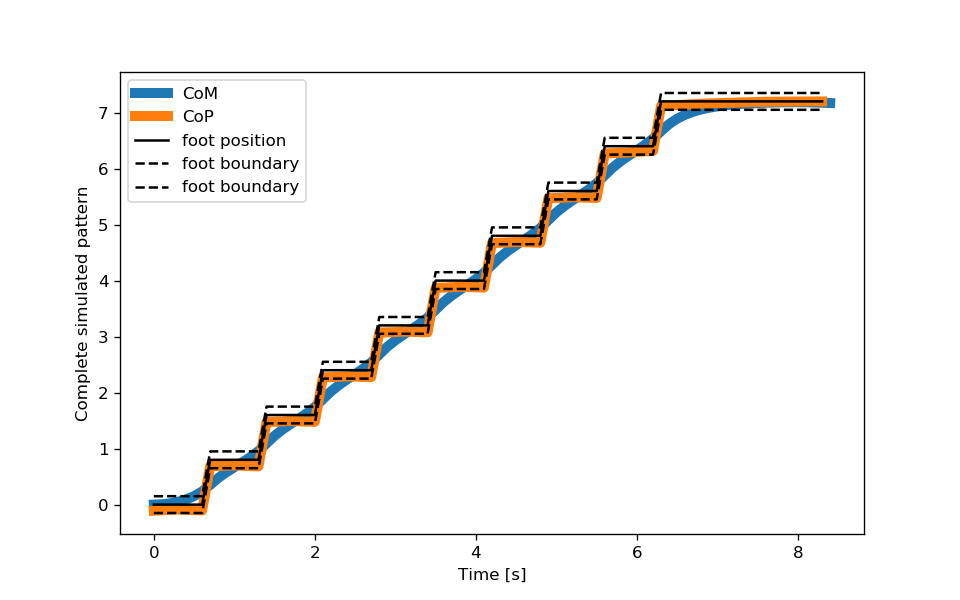

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABkQW1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9NiBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAAxtZYiE
AD///vdonwKbWkN6gOSVxSXbT4H/q2dwfI/pAwAAAwAAAwAAAwAAdaFhgCmhz+EeJXEB8N6fIJ7J
rhIV+NN9XHf+yK6HekcsMNjoKvvXtcbZXakH3+0/LRAyQe9DPegHzrQHdhsvQ4TB5VWNUlazi2pz
HLTm3LWoAhG5OLuAY3QccEzKvAIoQXkur8b0BVsDtVlWB2K7+mRvOiArDXft8+uPLEnmegL/YwMb
JR8p5s4d8AjPr0pultWHQgLAfHe0lTv/mUCH0PuAwFyBY6YQGW5jnHcLtsMMX/kHJRNiFFZOyAg8
KZERem053To7jaAgNt9WFoQ99IPMYWs+zbaqdD9h5b8xEqfFyeF72aOsc5JTylOv6nKJWiHelOzN
8OGnvPgKdHIlXHA4YEIySeC9dhUym9lgfsmBa/3PRrSJStzOz4YbTYrNEwcQm0Myjfd5HVjmPyk3
HZEZxhoFgdGsEBCujqtfUzAc5W+dU598s6MgYI7SPQsmPcakqOVN+6sONzQldFsEXd8zQ1tLkN0S
V20ZoWvUPeA8b2aUxLFlujZM3+xHO+xz4ardGrXx5//IdnLlbawbcEfUtOba4TI6KkWLNohh9Z2P
nluqm5kFUUG0tiO75xvqDBVnOsSqlleHM3C55Ht07/S916VauJ7xcJd02jTwyS7fwSg6m/9Ow/OT
ksCq2e0mwI93IpCyvH+BK/Im6xtA3MFAjlOc6qDEYAch96ntX6Hq/NGhlgdHY0oH/1P/2tO2Yr3A
USRGAu8n6+67jca0BcWh4bI4UyulBf6+BoSBXSJLiV9afhFnPo8mijkOpKM+1XZafL3pY43xCqcA
j47xA0GOpZaX+W+ENkFeN4VPBLyx8eiOJXZtS4dqgnNpJRE6ueUydenVk69vP9Nw4XcTDrv1z561
AjHaDdBGSdBoTUNZ5GOt/kRZkAxi9zhb/8vqsHM8wIAAAZxB44zOUMXLuEeCqmBLWKeW70eMvScF
jZtvBSZabzapwy0oYXwdLj4MZeoBYw3KUTo5zA1A74kOnAbt4O2J/76q7Ws7RP+Dz+b1vnEOurYU
8qPW8F0Dcbvwa1EOaJhr1XmNNIHrc4U+1hSAHSDHvy4qvotAsrNdl5TQ9oIsMbaYCJZj5OMjEiK/
oKrEQIUHjUOPKqXAdAfxV27SlaSV8PSxEQxaMuO04MztriEhZws685ilhW3zcH34Hd8nkkezfEBA
bHcvYXS8QW0W9VRmoPMfzhj6NHu75Xr5sDalKIWRblzbIItCwEFExLTNjVcCvp3jHK0sy8SqSLBP
9kTs3H9J1z67tikfSXXCj9pggCN15EDp00qt/iNOZk7J+nLZNhkQ/MaPjlzBAawP/obBYhkT/Jgv
faTIuGIvzLlh0NEyR5Dh1x2bX/w7ozbnigxl4Bc2GJ+XwQy6zrt2HkrvimXsb0QahtdJ3E0WpREn
+O2Fv51yBIF7f3G5EQprWosqKo1/KNsi4gtiqFLMnEG32ZW4mR+Mywra5lArvIUapvXZcwDeL03W
7bOAaoizO0mxnVcuLZlXF5OhrGW3JXi+o+rt8W05H3YhD1wFgl0oBSqkNfRu+wPFQJmVbAOERoha
R40pG7czBGysybti9wfbWq8JIbiCM+mvpCP93AyvgxZrN58x5ZgQl7XqrLOmUjq75bW3mW7gYrKq
9aFA/lCTTUT8b+jgRfJqKBUUpDzLXBYdF4ZlI5yczinqh7pLZD75Sf2YfmKtLG63C6URtJzve3iz
LHqqdDg1FPRWRoUa+Av7r8rwVRZQHvFK1AknJkQqAf3Jwf2aqD/3idMOIpHOq6kWjS6P8Xobyuxf
+tBzjny8peDUofBQDMph0amEw5ozmSiC+hBqFGGbPdP/UV7UIR9Ni3A4+419EffXOEAmP85pakvx
sq7ZWHmrUjEMR2LrYrt5BwuyP8WPwY6t7xjsz5z0PrWfIuHg4CUvHxX8tLdSrSf6wuX2BOof82gL
ZEz5WYrtGSN7naverMJYddyziV9RU0rtDFXFvcZFP37bn8G/CrO+HZly1JU5mHtqT5oid7FHfsLs
qBZkn/SWecA7/Ft84akQccU4ADzvQ14FxRsjtm6VYTCp7b24vTOlJqamsq/+t94ExNG9KrSIl9OC
feonzzizNeIajM2JmbDpbXryB/q9u5rN3BAahUBOuChX8iabnvE2HEDNfirv3gFtN+9/Apw0kSo+
7FDT5OElvOonKMK43KqV0Bkoqbi6QJG4bRXi3KVzIbualmZMU9B7jzk0dVyE4hfZGyH62yuE1F4d
bnPG8rc/wriilUVEKC2ZY0oq7j99HQOCxv8ON9R3f51N3tII+ris6atSuXPrWZY/mxSJ9k6V3ZgA
nm83W5CSS9CAZ3pt1ExnFPIduDEeiqNONJ995z2/a6IPu5aur160UqoY9GRbq/4dqgG2j5eoCZ2Y
vqJEHrq8SGTGDfEV5VWP3tcLizL3oODvDMc4kONAZKu2cUz4CG8hIlMgbK/yZAR2eFcXKiVm6ViZ
biZbsxp4StPAo2+qwTBdtJUDGt6WbZ9jsALCCpvfWttCLpW7ACZRFXCnj0Q6YUyQAAADAIsFdGWM
8GtDRwttJAkUf9fyW3TT041PNTU+2HG/GJDCOL9eUhgBvSSfDu5q74tpPK8PdVs96XxMNPlbbvkc
uRlO5OD+/sxX8IH1F94jioWeBkicvf3NPkieudp9N/YdJPzT7m3d5yIfAKOSE3TYeiog1rtinlKW
xye0XweF5LmycvMibkatPkm4FC5UJtJMadxJFdRPDc9JSMlGQpVK19LuicLSlXv/pkbbLsBRr/P4
rDEwnIjp5SnzsAdjYlq9B7+SdjJdrUUboEFQp+j0XmvhHANWYtDbgjf+n82xgVAggzPFsbOgggk6
Q1BWR17us9TfcfqHrGAku

In [30]:
x_real = np.empty([2,horizon_length+1])
u_real = np.empty([1,horizon_length])
x_real[:,0] = np.array([0.,0.])

Test_Horizon = 11

# we will fill the lists for each time step
for i in range(horizon_length):
    last_index = i + Test_Horizon
    if last_index >= horizon_length:
        last_index = horizon_length
    Test_Horizon_Current = last_index - i 
    
    Q_current = Q[i:last_index]
    q_current = q[i:last_index]
    
    R_current = R[i:last_index]
    r_current = r[i:last_index]
    
    G_bounds_current = G_bounds[i:last_index]
    h_bounds_current = h_bounds[i:last_index]
    foot_position_current = foot_position[i:last_index]
    
    
    x0_current = x_real[:,i]
    horizon_length_current = Test_Horizon_Current;
    
    x_plan_current, u_plan_current = solve_mpc_collocation(walking_model.A,walking_model.B, Q_current, q_current, R_current, r_current, G_bounds_current, h_bounds_current,Test_Horizon_Current,x0_current)
    
    # we now define a controller that will simply use the computed u as a control
    feedforward_controller = lambda x,i: u_plan_current[0,i]
    
    x,u = walking_model.simulate(x0_current, feedforward_controller, horizon_length_current, foot_position_current, noise=True)
    u_real[:,i]= u[:,0]
    x_real[:,i+1] = x[:,1]
    
    
# now we can solve the problem using the collocation method (solving a single quadratic program gives a x and u trajectory in time)
x_plan, u_plan = solve_mpc_collocation(walking_model.A,walking_model.B,Q,q,R,r,G_bounds, h_bounds, horizon_length, x0)

# Generating Plots and Animation for comparision
plot_results(x_real, u_real, x_plan, u_plan)
animate_walker(x_real, u_real, foot_position)

c) Relate this horizon time to the duration of one step. How many steps in advance is it necessary to plan for to get a stable controller?


### Answer:
2 steps are necessary to plan a stable controller. As it takes 0.7 seconds to take one step and since it requires minimum horizon length of 11 for stable walking. Planning 2 steps in advance is mandatory. 

## d) How different is the executed control compared to the originally planned one?

### Answer
Though the executed control in case when we choose minimum horizon length is able to keep the system stable and able to keep COM velocity and COM position nearly close to as desired, it is not able to follow the COP as expected. The COP for the minumum horizon length is marginally under the constraints and pretty far off the planned COP (planned controls) towards the lower bounds of foot limit.


## e) What happens if you change the weights in the cost function? What if you increase the terminal cost (e.g. to $10^9$)? Can you decrease or increase the receding horizon length? Describe qualitatively the behavior you observe.

### Answer
On Increasing weights of the cost function the behaviour will certainly change. Increasing R makes the walking smoother whereas increasing Q makes it worse. 
On increasing terminal cost, the robot will still be able to walk but with some disturbances. 
Increasing receding horizon make the walking smoother and reducing it makes is have a bad behaviour.